# 1. Введение

Текущая ситуация: В России, особенно в крупных городах, проблема загрязнения воздуха является актуальной. Отсутствие доступной и понятной информации о качестве воздуха затрудняет принятие мер для защиты здоровья, особенно для людей с хроническими заболеваниями дыхательных путей.

* Существующие проблемы:
    * Отсутствие  единой платформы для сбора и анализа данных о качестве воздуха. 
    * Сложность интерпретации технических данных о загрязнении воздуха для обычного пользователя. 
    * Недостаток инструментов для прогнозирования качества воздуха на ближайшее будущее.
      
* Влияние на пользователей:
    * Ухудшение здоровья, особенно у детей и пожилых людей. 
    * Снижение качества жизни из-за необходимости ограничивать активность на открытом воздухе. 
    * Увеличение расходов на здравоохранение. 

PM2.5 - это загрязнители воздуха диаметром 2,5 микрометра. Твердые частицы (ТЧ) являются распространенным косвенным показателем загрязнения воздуха. Имеются убедительные доказательства негативного воздействия этого загрязнителя на здоровье человека. Основными компонентами ТЧ являются сульфаты, нитраты, аммиак, хлорид натрия, технический углерод, минеральная пыль и вода.
Согласно статье "Загрязнение воздуха: невидимый убийца под названием PM2.5" (https://www.mcgill.ca/newsroom/channels/news/air-pollution-silent-killer-called-pm25-329428)  "Среди различных видов загрязнения воздуха PM2.5 является наиболее опасным для людей во всем мире. Он состоит из частиц размером менее 2,5 микрометров – настолько мелких, что миллиарды из них могут поместиться внутри эритроцита. Более половины населения мира остро нуждается в защите в виде адекватных стандартов качества окружающего воздуха в отношении PM2.5. Внедрение этих стандартов повсеместно спасет бесчисленное количество жизней. А там, где стандарты уже существуют, их следует гармонизировать на глобальном уровне."


Поэтому для нас очень важно прогнозировать уровень загрязнепнности воздуха, в частности показатель PM2.5. В этом блокноте мы попыталиь найти подходящие модели прогнозирования. 

# 2. Знакомство с данными, базовый анализ

In [3]:
# !pip install tensorflow
# !pip install keras
# !pip install holidays
# !pip install meteostat
# !pip install prophet
# !pip install ipykernel

## Библиотеки

Первым этапом анализа данных и тренировки модели является импортирование нужных  библиотек. 

In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import datetime
import math
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras import optimizers

from keras import optimizers
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn import metrics

from tqdm import tqdm
plt.style.use("fivethirtyeight")

import holidays
import pandas as pd
import numpy as np

import optuna

## Чтение исходных данных
Прочитаем исходные данные с  данными о концентрации PM2.5 в городе Томске. Они были заранее выгружены с ресурса https://aqicn.org/ (доступ только через VPN) - единственное  место, гле удалось найти  данные для городов России за большой промежуток времени (с 2020 года).

In [7]:
# Указываем, какие столбцы нужно загрузить
columns_to_load = ['date', 'median']

# Читаем данные, загружая только нужные столбцы
df_pm25 = pd.read_csv("tomsk_pm25.csv", 
                 skiprows=3,  # Skip the first 3 rows (comments)
                 usecols=columns_to_load 
                 ) 

# Преобразуем столбец 'date' в формат datetime
df_pm25['date'] = pd.to_datetime(df_pm25['date'])
# Переименовываем столбец median в pm25
df_pm25.rename(columns={'median': 'pm25'}, inplace=True)
df_pm25['date'] = df_pm25['date'].dt.tz_localize(None)
# Проверяем результат
df_pm25

,date,pm25
0,2020-09-30,5.35
1,2020-10-01,0.93
2,2020-10-02,1.89
3,2020-10-03,5.37
4,2020-10-04,4.09
...,...,...
1531,2025-01-28,7.43
1532,2025-01-29,10.09
1533,2025-01-30,5.27
1534,2025-01-31,6.93


Загрузим метеоданные с ресурса  https://dev.meteostat.net/, используя модуль meteostat,  за тот же период времени.

In [9]:
from meteostat import Stations, Daily

start = df_pm25['date'].min()
end = df_pm25['date'].max()

# Загрузим метеоданные дляs tation 29430 = Tomsk
data = Daily('29430', start, end)
df_weather = data.fetch()
# преобразуем индекс в столбец 'date'
df_weather['date'] = df_weather.index
df_weather


,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,date
time,,,,,,,,,,,
2020-09-30,1.9,-2.3,6.3,NaN,NaN,275.0,2.9,NaN,1030.2,NaN,2020-09-30
2020-10-01,3.4,2.4,5.7,NaN,NaN,293.0,3.1,NaN,1027.0,NaN,2020-10-01
2020-10-02,4.2,1.7,6.9,NaN,NaN,170.0,1.5,NaN,1029.7,NaN,2020-10-02
2020-10-03,8.2,5.4,12.8,NaN,NaN,187.0,3.6,NaN,1022.0,NaN,2020-10-03
2020-10-04,8.1,5.3,12.0,NaN,NaN,194.0,4.1,NaN,1016.0,NaN,2020-10-04
...,...,...,...,...,...,...,...,...,...,...,...
2025-01-28,-11.1,-13.3,-9.0,NaN,NaN,100.0,2.7,NaN,1018.6,NaN,2025-01-28
2025-01-29,-14.9,-17.9,-11.7,NaN,NaN,66.0,1.7,NaN,1022.7,NaN,2025-01-29
2025-01-30,-16.7,-19.4,-14.2,NaN,NaN,44.0,4.6,NaN,1026.0,NaN,2025-01-30



Каждый день представлен строкой в Pandas DataFrame, которая содержит метеорологические данные, зарегистрированные в этот день. Вот различные столбцы:
| Столбец | Описание                                      | Тип      |
|---------|-----------------------------------------------|---------|
| time    | Дата                                          | Datetime64 |
| tavg    | Средняя температура воздуха в °C                | Float64  |
| tmin    | Минимальная температура воздуха в °C           | Float64  |
| tmax    | Максимальная температура воздуха в °C           | Float64  |
| prcp    | Общее суточное количество осадков в мм         | Float64  |
| snow    | Высота снежного покрова в мм                   | Float64  |
| wdir    | Среднее направление ветра в градусах (°)       | Float64  |
| wspd    | Средняя скорость ветра в км/ч                   | Float64  |
| wpgt    | Пиковый порыв ветра в км/ч                     | Float64  |
| pres    | Среднее атмосферное давление на уровне моря в гПа | Float64  |
| tsun    | Общая продолжительность солнечного сияния в минутах (м) | Float64  |

## 3. Разведывательный анализ данных (EDA)
Посмотрим как ведет себя показатель PM2.5

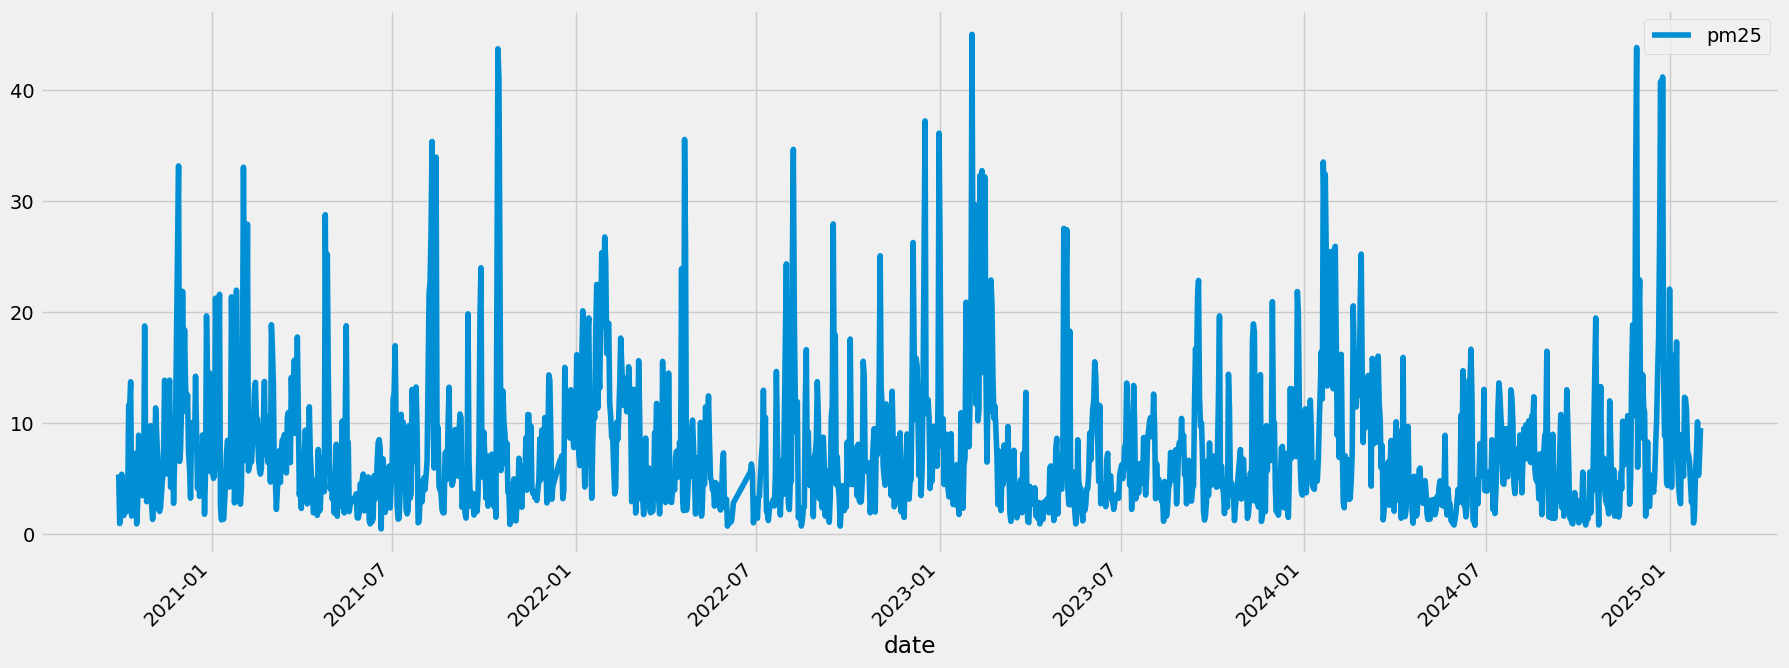

In [12]:
df_pm25.plot(x='date',y='pm25',figsize=(20,8))
plt.xticks(rotation=45)
plt.show()



 ---
 __Видно, что есть сезонные колебания  показателя.__

 ---


### График показателя PM2.5, усредненного по годам

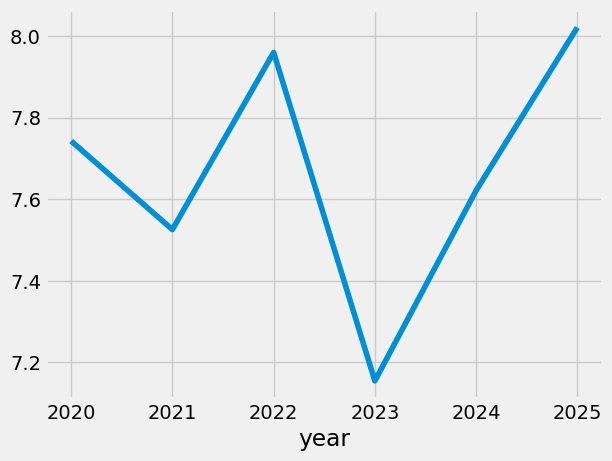

In [15]:
df=df_pm25.copy()
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['day_of_week'] = df['date'].dt.day_name()
df.groupby('year')['pm25'].mean().plot()
plt.show()

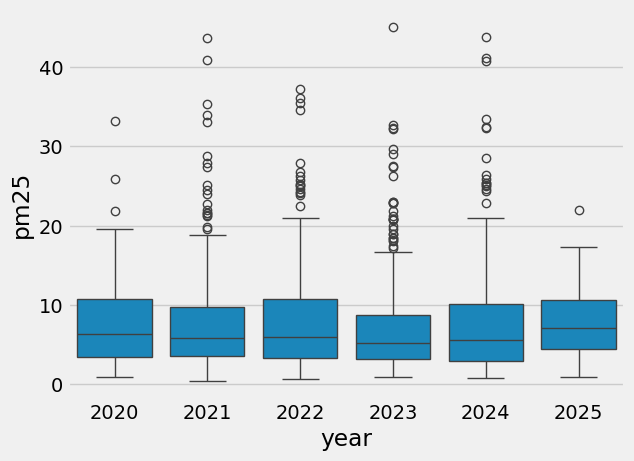

In [16]:
df_year=df.loc[:,['year','pm25']]
sns.boxplot(x='year', y='pm25',data=df_year)
plt.show()

 ---
 __Явная зависимость не прослеживается__

 ---

### График показателя PM2.5, усредненного по месяцам

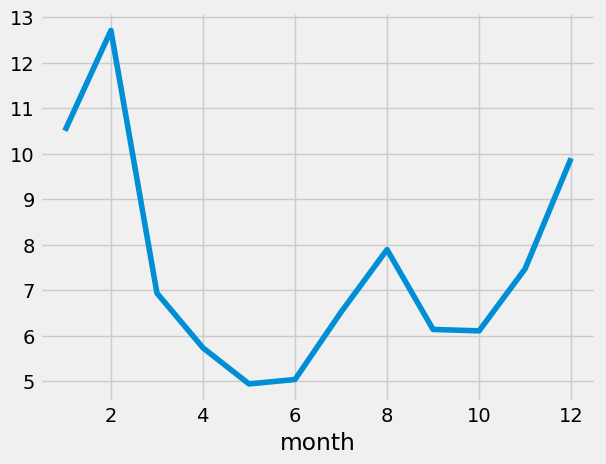

In [19]:
df.groupby('month')['pm25'].mean().plot()
plt.show()

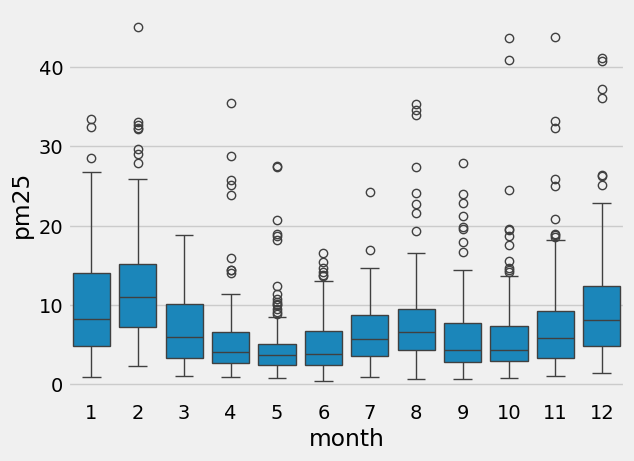

In [20]:
df_month=df.loc[:,['month','pm25']]
sns.boxplot(x='month', y='pm25',data=df_month)
plt.show()

 ---
 __Есть явная сезонная зависимость__

 ---


### График показателя PM2.5, усредненного по дням месяца

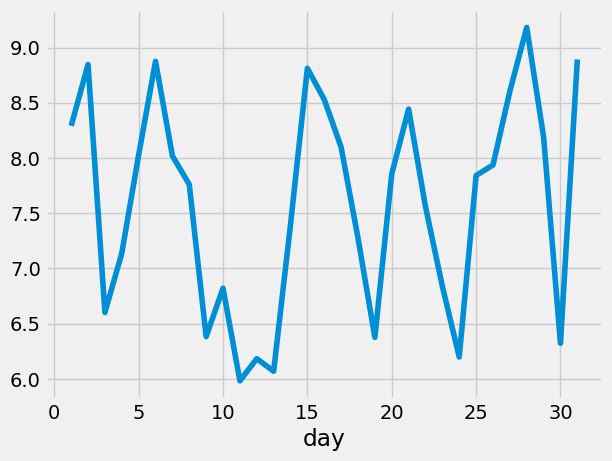

In [23]:
df.groupby('day')['pm25'].mean().plot()
plt.show()

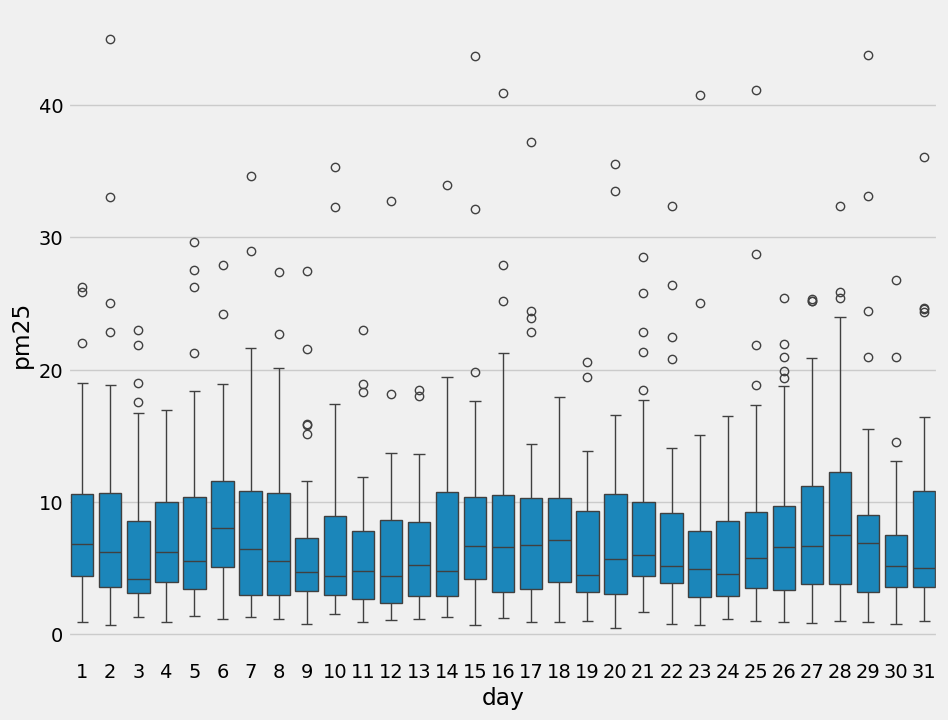

In [24]:
df_day=df.loc[:,['day','pm25']]
plt.figure(figsize=(10,8))
sns.boxplot(x='day', y='pm25',data=df_day)
plt.show()

 ---
 __Явная зависимость не прослеживается__

 ---

### График показателя PM2.5, усредненного по дням недели

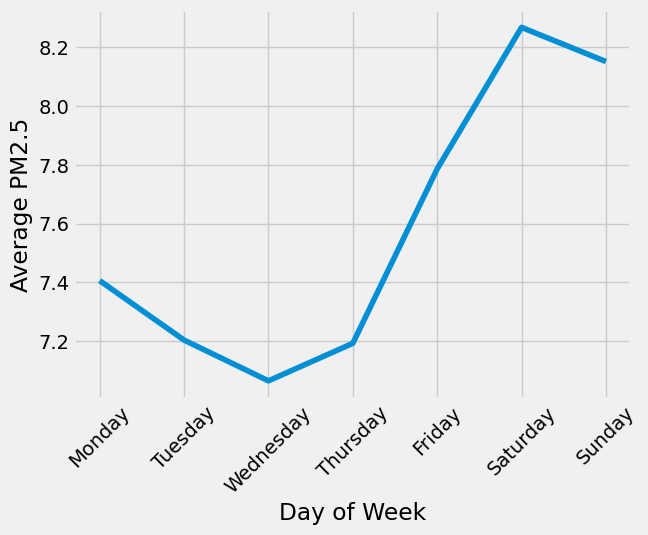

In [27]:
# Лпределим порядок дней недели
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# сгруппируем по 'day_of_week' и вычислим среднее 'pm25'
grouped_df = df.groupby('day_of_week')['pm25'].mean()
# переиндексируем по weekday_order
grouped_df = grouped_df.reindex(weekday_order)
grouped_df.plot( xlabel='Day of Week', ylabel='Average PM2.5')
plt.xticks(rotation=45)
plt.show()

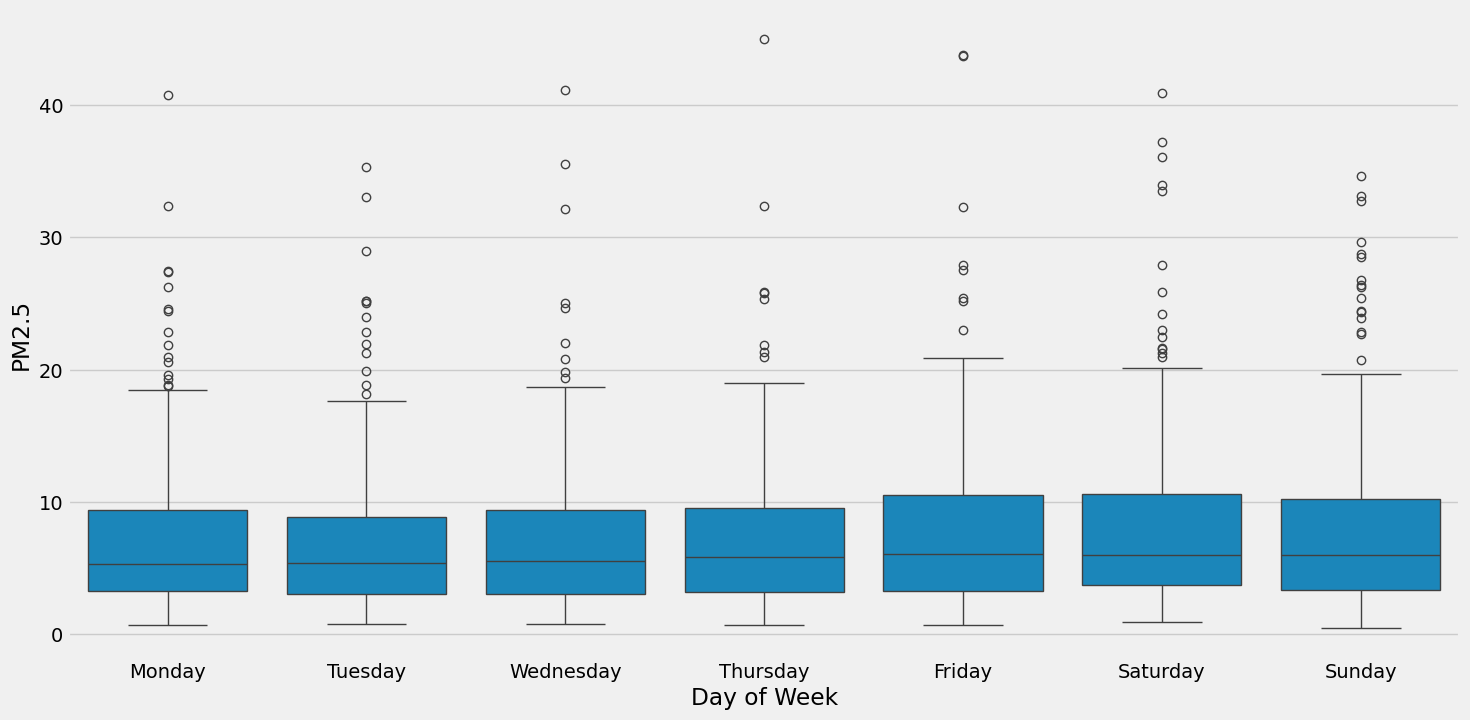

In [28]:
df_day=df.loc[:,['day','pm25']]
plt.figure(figsize=(16,8))
sns.boxplot(x='day_of_week', y='pm25', data=df, order=weekday_order)
plt.xlabel('Day of Week')
plt.ylabel('PM2.5')

plt.show()

## 4. Подготовка данных

### Слияние метеоданных и данных о показателе PM2.5

In [31]:
# Слияние данных
df_merged = pd.merge(df_weather, df_pm25, on='date', how='left')

# Сохранение результата
df_merged.to_csv('tomsk_merged.csv', index=False)

df_merged

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,date,pm25
0,1.9,-2.3,6.3,NaN,NaN,275.0,2.9,NaN,1030.2,NaN,2020-09-30,5.35
1,3.4,2.4,5.7,NaN,NaN,293.0,3.1,NaN,1027.0,NaN,2020-10-01,0.93
2,4.2,1.7,6.9,NaN,NaN,170.0,1.5,NaN,1029.7,NaN,2020-10-02,1.89
3,8.2,5.4,12.8,NaN,NaN,187.0,3.6,NaN,1022.0,NaN,2020-10-03,5.37
4,8.1,5.3,12.0,NaN,NaN,194.0,4.1,NaN,1016.0,NaN,2020-10-04,4.09
...,...,...,...,...,...,...,...,...,...,...,...,...
1581,-11.1,-13.3,-9.0,NaN,NaN,100.0,2.7,NaN,1018.6,NaN,2025-01-28,7.43
1582,-14.9,-17.9,-11.7,NaN,NaN,66.0,1.7,NaN,1022.7,NaN,2025-01-29,10.09
1583,-16.7,-19.4,-14.2,NaN,NaN,44.0,4.6,NaN,1026.0,NaN,2025-01-30,5.27
1584,-18.3,-20.0,-15.0,NaN,NaN,36.0,3.0,NaN,1027.5,NaN,2025-01-31,6.93


### Проверка на отсутствующие значения
Вначале проверим датасет на отсутсвующие значения

In [33]:
print(df_merged.shape)
print(df_merged.info())

(1586, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1586 entries, 0 to 1585
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   tavg    1586 non-null   float64       
 1   tmin    1586 non-null   float64       
 2   tmax    1586 non-null   float64       
 3   prcp    34 non-null     float64       
 4   snow    0 non-null      float64       
 5   wdir    1566 non-null   float64       
 6   wspd    1586 non-null   float64       
 7   wpgt    0 non-null      float64       
 8   pres    1586 non-null   float64       
 9   tsun    0 non-null      float64       
 10  date    1586 non-null   datetime64[ns]
 11  pm25    1536 non-null   float64       
dtypes: datetime64[ns](1), float64(11)
memory usage: 148.8 KB
None


Удалим столбцы с большим количеством NаN или полностью заполненные NaN

In [35]:
df_merged.dropna(how='all', axis=1, inplace=True) 
df_merged.drop(['prcp','tmin','tmax'], axis=1, inplace=True) 
df_merged

,tavg,wdir,wspd,pres,date,pm25
0,1.9,275.0,2.9,1030.2,2020-09-30,5.35
1,3.4,293.0,3.1,1027.0,2020-10-01,0.93
2,4.2,170.0,1.5,1029.7,2020-10-02,1.89
3,8.2,187.0,3.6,1022.0,2020-10-03,5.37
4,8.1,194.0,4.1,1016.0,2020-10-04,4.09
...,...,...,...,...,...,...
1581,-11.1,100.0,2.7,1018.6,2025-01-28,7.43
1582,-14.9,66.0,1.7,1022.7,2025-01-29,10.09
1583,-16.7,44.0,4.6,1026.0,2025-01-30,5.27
1584,-18.3,36.0,3.0,1027.5,2025-01-31,6.93


Есть несколько пропущенныз значений в столбцах pm25 и pwind, заполним их, используя KNNImputer – это метод в машинном обучении, используемый для заполнения пропущенных значений в данных. Он работает на основе принципа k ближайших соседей (KNN)

In [37]:
from sklearn.impute import KNNImputer

cols_to_impute = ['pm25', 'wdir']
df_imputed = df_merged.copy()
imputer = KNNImputer(n_neighbors=5)
df_imputed[cols_to_impute] = imputer.fit_transform(df_imputed[cols_to_impute])
print(df_imputed) 

      tavg   wdir  wspd    pres       date   pm25
0      1.9  275.0   2.9  1030.2 2020-09-30   5.35
1      3.4  293.0   3.1  1027.0 2020-10-01   0.93
2      4.2  170.0   1.5  1029.7 2020-10-02   1.89
3      8.2  187.0   3.6  1022.0 2020-10-03   5.37
4      8.1  194.0   4.1  1016.0 2020-10-04   4.09
...    ...    ...   ...     ...        ...    ...
1581 -11.1  100.0   2.7  1018.6 2025-01-28   7.43
1582 -14.9   66.0   1.7  1022.7 2025-01-29  10.09
1583 -16.7   44.0   4.6  1026.0 2025-01-30   5.27
1584 -18.3   36.0   3.0  1027.5 2025-01-31   6.93
1585 -19.5  206.0   0.6  1034.4 2025-02-01   9.52

[1586 rows x 6 columns]


## Добавление новых признаков 
Мы собираемся прогнозировать временные ряды с помощью методов регрессии, поэтому  выбор подходящих признаков играет ключевую роль в повышении точности модели. 
Вот некоторые из признаков, которые можно добавить:
1. Значения целевой переменной в предыдущие моменты времени (например, за предыдущий день, неделю, месяц).
2. Созданные на основе даты:
* День недели: Может иметь значение для некоторых видов загрязнения, связанных с человеческой активностью.
* Месяц: Сезонные колебания могут влиять на концентрацию PM2.5.
* Праздники: Можно добавить индикаторные переменные для праздников, когда уровень загрязнения может отличаться.
* Выходные дни: Может быть полезно для некоторых видов загрязнения, связанных с промышленной деятельностью.
3. Инженерные признаки на основе имеющихся:
* Скорость ветра по направлениям: Разложить вектор скорости ветра на компоненты (например, северный, южный, западный, восточный) для анализа влияния направления ветра.
* Скользящие средние и экспоненциальное сглаживание: Для сглаживания временных рядов и выделения трендов.
* Разности и процентные изменения: Для выявления сезонности и трендов.

Добавим значения целевой переменной в предыдущие моменты времени 

In [40]:
df_featadded = df_imputed.copy()

df_featadded['pm25-1'] = df_featadded['pm25'].shift(1)
df_featadded['pm25-2'] = df_featadded['pm25'].shift(2)

Создадим переменные на основе даты на основе даты:

In [42]:
df_featadded['date'] = pd.to_datetime(df_featadded['date'])
df_featadded['year'] = df_featadded['date'].dt.year
df_featadded['month'] = df_featadded['date'].dt.month_name()
df_featadded['day'] = df_featadded['date'].dt.day
df_featadded['day_of_week'] = df_featadded['date'].dt.day_name()

Отмечаем дни, являющиеся праздничными в России 

In [44]:
ru_holidays = holidays.RU()
df_featadded['is_holiday'] = df_featadded['date'].apply(lambda x: x in ru_holidays)

Добавим Скорость ветра по направлениям:

In [46]:
def categorize_wind_direction(wdir):
    """
    Categorizes wind direction into 8 categories (N, NE, E, SE, S, SW, W, NW).

    Args:
        wdir: Wind direction in degrees (0-360).

    Returns:
        str: Categorized wind direction (N, NE, E, SE, S, SW, W, NW).
    """
    directions = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']
    index = int((wdir + 22.5) // 45) % 8  # Calculate index for 8 categories
    return directions[index]

# Apply the function to create a new column
df_featadded['winddir'] = df_featadded['wdir'].apply(categorize_wind_direction)

Добавим остальные признаки 

In [48]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

df=df_featadded.copy()
# 1. One-Hot Encoding  для категорийных признаков

# 1.1 Создаем список категориальных признаков
categorical_features = ['day_of_week', 'winddir']

# 1.2 Инициализируем OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore') 

# 1.3 Применяем кодирование к категориальным признакам
encoded_features = encoder.fit_transform(df[categorical_features])

# 1.4 Создаем новый DataFrame из закодированных признаков
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_features))

# 1.5 Объединяем закодированный DataFrame с исходным
df_featencoded = pd.concat([df, encoded_df], axis=1)

# 3.1 Вычисляем разницу температур между днями
df_featencoded['temperature_diff'] = df_featencoded['tavg'].diff()

# 3.2 Вычисляем изменение скорости ветра между днями
df_featencoded['wind_speed_change'] = df_featencoded['wspd'].diff()

# 3.2 Вычисляем изменение атм.давления между днями
df_featencoded['pressure_change'] = df_featencoded['pres'].diff()

Добавим свой вариант таргет-энкодинга, кторый учитывает данные только предыдущих наблюдений, в не всех значений.

In [50]:
# Функция для вычисления среднего значения pm25 для предыдущих наблюдений
def calculate_target_encoding(df, col, target):
    """
    Вычисляет целевое кодирование для категориальной переменной.

    Args:
        df: DataFrame с данными.
        col: Категориальная переменная.
        target: Целевая переменная.

    Returns:
        Series с целевым кодированием.
    """
    
    # Создаем новый столбец для целевого кодирования
    df[f'{col}_target_encoded'] = None

    # Итерируемся по каждой строке
    for i in range(1, len(df)):
        # Вычисляем среднее значение target для предыдущих наблюдений с той же категорией
        df.loc[i, f'{col}_target_encoded'] = df[df[col] == df.loc[i, col]].iloc[:i][target].mean()

    return df

# Применяем функцию к нашим данным
df_featencoded = calculate_target_encoding(df_featencoded, 'month', 'pm25')

Теперь в DataFrame  содержатся:
- One-hot encoded признаки для 'month', 'day_of_week' и 'winddir'
- Новые признаки: 'temperature_diff', 'wind_speed_change', 'pressure_change'
- новый признак 'month_target_encoded'

 Теперь можно продолжить анализ данных ипостроение модели.

In [52]:
df_featencoded

,tavg,wdir,wspd,pres,date,pm25,pm25-1,pm25-2,year,month,...,winddir_NE,winddir_NW,winddir_S,winddir_SE,winddir_SW,winddir_W,temperature_diff,wind_speed_change,pressure_change,month_target_encoded
0,1.9,275.0,2.9,1030.2,2020-09-30,5.35,NaN,NaN,2020,September,...,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,None
1,3.4,293.0,3.1,1027.0,2020-10-01,0.93,5.35,NaN,2020,October,...,0.0,1.0,0.0,0.0,0.0,0.0,1.5,0.2,-3.2,0.93
2,4.2,170.0,1.5,1029.7,2020-10-02,1.89,0.93,5.35,2020,October,...,0.0,0.0,1.0,0.0,0.0,0.0,0.8,-1.6,2.7,1.41
3,8.2,187.0,3.6,1022.0,2020-10-03,5.37,1.89,0.93,2020,October,...,0.0,0.0,1.0,0.0,0.0,0.0,4.0,2.1,-7.7,2.73
4,8.1,194.0,4.1,1016.0,2020-10-04,4.09,5.37,1.89,2020,October,...,0.0,0.0,1.0,0.0,0.0,0.0,-0.1,0.5,-6.0,3.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1581,-11.1,100.0,2.7,1018.6,2025-01-28,7.43,5.63,1.85,2025,January,...,0.0,0.0,0.0,0.0,0.0,0.0,1.8,0.7,-12.0,10.501742
1582,-14.9,66.0,1.7,1022.7,2025-01-29,10.09,7.43,5.63,2025,January,...,1.0,0.0,0.0,0.0,0.0,0.0,-3.8,-1.0,4.1,10.501742
1583,-16.7,44.0,4.6,1026.0,2025-01-30,5.27,10.09,7.43,2025,January,...,1.0,0.0,0.0,0.0,0.0,0.0,-1.8,2.9,3.3,10.501742
1584,-18.3,36.0,3.0,1027.5,2025-01-31,6.93,5.27,10.09,2025,January,...,1.0,0.0,0.0,0.0,0.0,0.0,-1.6,-1.6,1.5,10.501742


In [53]:
df_featencoded.set_index('date', inplace=True)
df_featencoded

,tavg,wdir,wspd,pres,pm25,pm25-1,pm25-2,year,month,day,...,winddir_NE,winddir_NW,winddir_S,winddir_SE,winddir_SW,winddir_W,temperature_diff,wind_speed_change,pressure_change,month_target_encoded
date,,,,,,,,,,,,,,,,,,,,,
2020-09-30,1.9,275.0,2.9,1030.2,5.35,NaN,NaN,2020,September,30,...,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,None
2020-10-01,3.4,293.0,3.1,1027.0,0.93,5.35,NaN,2020,October,1,...,0.0,1.0,0.0,0.0,0.0,0.0,1.5,0.2,-3.2,0.93
2020-10-02,4.2,170.0,1.5,1029.7,1.89,0.93,5.35,2020,October,2,...,0.0,0.0,1.0,0.0,0.0,0.0,0.8,-1.6,2.7,1.41
2020-10-03,8.2,187.0,3.6,1022.0,5.37,1.89,0.93,2020,October,3,...,0.0,0.0,1.0,0.0,0.0,0.0,4.0,2.1,-7.7,2.73
2020-10-04,8.1,194.0,4.1,1016.0,4.09,5.37,1.89,2020,October,4,...,0.0,0.0,1.0,0.0,0.0,0.0,-0.1,0.5,-6.0,3.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-28,-11.1,100.0,2.7,1018.6,7.43,5.63,1.85,2025,January,28,...,0.0,0.0,0.0,0.0,0.0,0.0,1.8,0.7,-12.0,10.501742
2025-01-29,-14.9,66.0,1.7,1022.7,10.09,7.43,5.63,2025,January,29,...,1.0,0.0,0.0,0.0,0.0,0.0,-3.8,-1.0,4.1,10.501742
2025-01-30,-16.7,44.0,4.6,1026.0,5.27,10.09,7.43,2025,January,30,...,1.0,0.0,0.0,0.0,0.0,0.0,-1.8,2.9,3.3,10.501742


In [54]:
df_featencoded['is_holiday'] = df_featencoded['is_holiday'].astype(int)
df_featencoded['month_target_encoded'] = df_featencoded['month_target_encoded'].astype(float)

df_featencoded.describe().T

,count,mean,std,min,25%,50%,75%,max
tavg,1586.0,1.248991,13.725021,-41.00,-8.800000,1.600000,13.0000,27.200000
wdir,1586.0,180.008769,88.199888,0.00,123.250000,190.000000,233.7500,360.000000
wspd,1586.0,3.448865,2.002926,0.00,2.100000,3.100000,4.4000,21.300000
pres,1586.0,1018.701765,11.780695,992.60,1009.800000,1017.500000,1026.3000,1062.600000
pm25,1586.0,7.583193,6.215616,0.45,3.305000,5.880000,9.9875,45.000000
pm25-1,1585.0,7.581971,6.217387,0.45,3.300000,5.880000,9.9900,45.000000
pm25-2,1584.0,7.582383,6.219329,0.45,3.300000,5.865000,9.9925,45.000000
year,1586.0,2022.404792,1.279324,2020.00,2021.000000,2022.000000,2024.0000,2025.000000
day,1586.0,15.740858,8.818481,1.00,8.000000,16.000000,23.0000,31.000000
is_holiday,1586.0,0.052963,0.224031,0.00,0.000000,0.000000,0.0000,1.000000


In [55]:
#df_cleant['is_holiday'] = df_cleant['is_holiday'].astype(int)
df_cleant = df_featencoded.drop(['wdir', 'year', 'winddir', 'month', 'day',  'day_of_week' ], axis=1)
df_cleant

,tavg,wspd,pres,pm25,pm25-1,pm25-2,is_holiday,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,...,winddir_NE,winddir_NW,winddir_S,winddir_SE,winddir_SW,winddir_W,temperature_diff,wind_speed_change,pressure_change,month_target_encoded
date,,,,,,,,,,,,,,,,,,,,,
2020-09-30,1.9,2.9,1030.2,5.35,NaN,NaN,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN
2020-10-01,3.4,3.1,1027.0,0.93,5.35,NaN,0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.5,0.2,-3.2,0.930000
2020-10-02,4.2,1.5,1029.7,1.89,0.93,5.35,0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.8,-1.6,2.7,1.410000
2020-10-03,8.2,3.6,1022.0,5.37,1.89,0.93,0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,4.0,2.1,-7.7,2.730000
2020-10-04,8.1,4.1,1016.0,4.09,5.37,1.89,0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,-0.1,0.5,-6.0,3.070000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-28,-11.1,2.7,1018.6,7.43,5.63,1.85,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.8,0.7,-12.0,10.501742
2025-01-29,-14.9,1.7,1022.7,10.09,7.43,5.63,0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,-3.8,-1.0,4.1,10.501742
2025-01-30,-16.7,4.6,1026.0,5.27,10.09,7.43,0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,-1.8,2.9,3.3,10.501742


Добавим целевую переменную - pm25-forecast - проноз  на завтра

In [57]:
df_cleant['pm25-forecast'] = df_cleant['pm25'].shift(-1)
df_cleant.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1586 entries, 2020-09-30 to 2025-02-01
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   tavg                   1586 non-null   float64
 1   wspd                   1586 non-null   float64
 2   pres                   1586 non-null   float64
 3   pm25                   1586 non-null   float64
 4   pm25-1                 1585 non-null   float64
 5   pm25-2                 1584 non-null   float64
 6   is_holiday             1586 non-null   int32  
 7   day_of_week_Friday     1586 non-null   float64
 8   day_of_week_Monday     1586 non-null   float64
 9   day_of_week_Saturday   1586 non-null   float64
 10  day_of_week_Sunday     1586 non-null   float64
 11  day_of_week_Thursday   1586 non-null   float64
 12  day_of_week_Tuesday    1586 non-null   float64
 13  day_of_week_Wednesday  1586 non-null   float64
 14  winddir_E              1586 non-null  

In [58]:
# # Удаляем первые три строки
# df_cleant = df_cleant.iloc[3:]

# # Удаляем последнюю строку
# df_cleant = df_cleant.iloc[:-1]

# df_cleant
start_date = '2021-01-01'
end_date = '2024-12-31'

# Фильтруем DataFrame по датам
df_cleant = df_cleant.loc[start_date:end_date]

df_cleant

,tavg,wspd,pres,pm25,pm25-1,pm25-2,is_holiday,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,...,winddir_NW,winddir_S,winddir_SE,winddir_SW,winddir_W,temperature_diff,wind_speed_change,pressure_change,month_target_encoded,pm25-forecast
date,,,,,,,,,,,,,,,,,,,,,
2021-01-01,-31.4,2.2,1044.4,13.02,5.60,14.50,1,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-10.1,-0.4,9.6,10.136882,5.63
2021-01-02,-28.1,2.4,1051.9,5.63,13.02,5.60,1,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,3.3,0.2,7.5,10.101170,5.00
2021-01-03,-31.7,2.2,1060.6,5.00,5.63,13.02,1,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,-3.6,-0.2,8.7,10.113368,5.25
2021-01-04,-26.9,3.6,1060.7,5.25,5.00,5.63,1,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,4.8,1.4,0.1,10.046563,21.23
2021-01-05,-26.5,1.0,1062.6,21.23,5.25,5.00,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.4,-2.6,1.9,10.021340,15.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-27,-12.1,2.5,1023.9,8.81,13.38,41.16,0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.6,1.0,-16.4,9.750400,10.07
2024-12-28,-8.8,2.8,1010.6,10.07,8.81,13.38,0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,3.3,0.3,-13.3,9.750400,4.63
2024-12-29,-6.1,5.4,1013.3,4.63,10.07,8.81,0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,2.7,2.6,2.7,9.750400,4.34


Построим тепловую карту корреляции признаков:

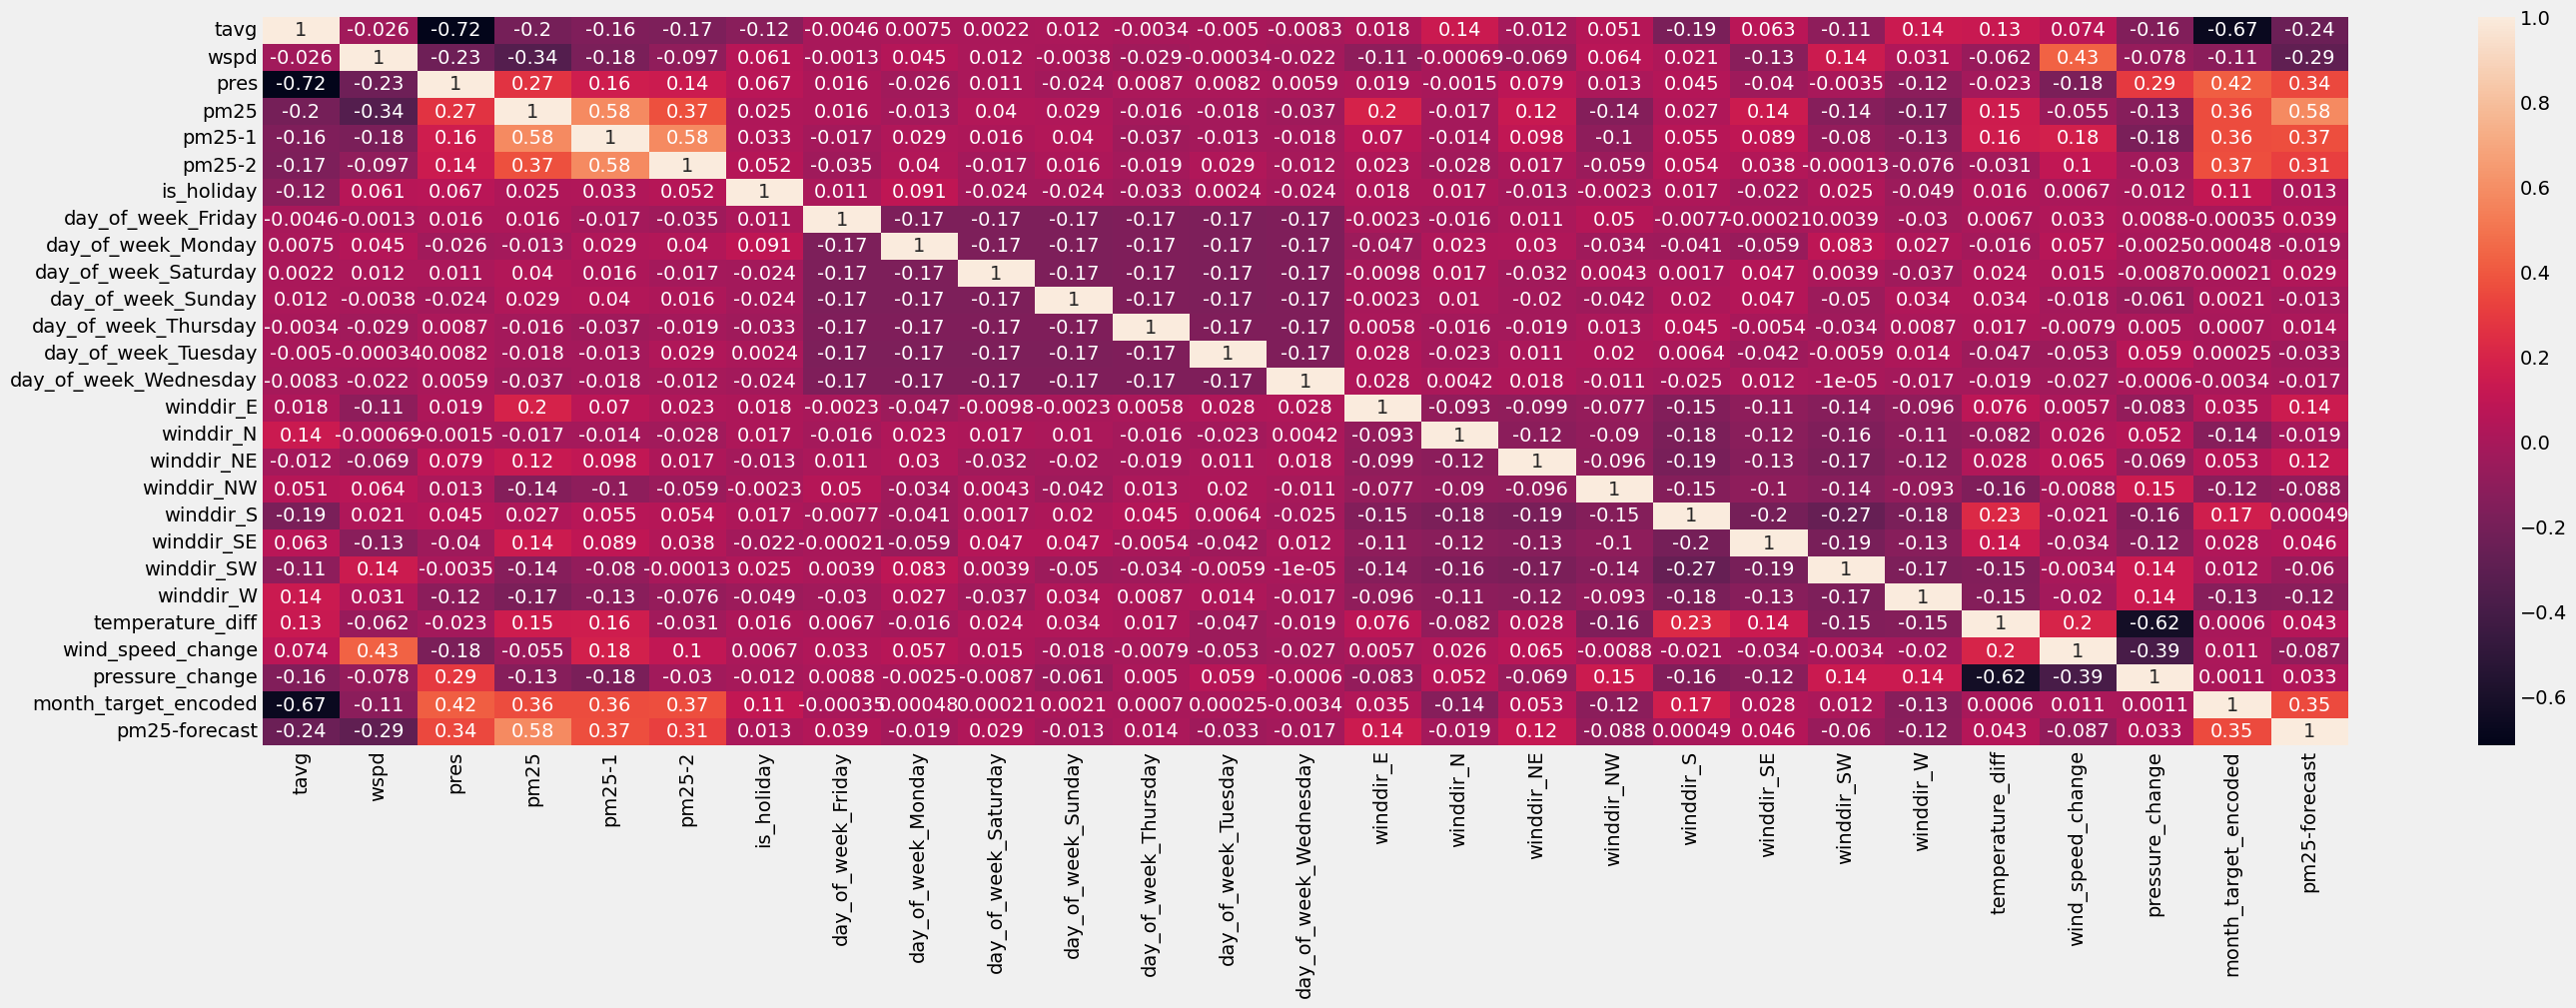

In [60]:
plt.figure(figsize=(30,9))
sns.heatmap(df_cleant.corr(),annot=True);
plt.show()

In [61]:
corr_matrix = df_cleant.corr()

# Выводим корреляцию 'pm25-forecast' с другими столбцами
print(corr_matrix['pm25-forecast'])


tavg                    -0.244238
wspd                    -0.292479
pres                     0.343562
pm25                     0.580730
pm25-1                   0.369175
pm25-2                   0.312433
is_holiday               0.012616
day_of_week_Friday       0.039403
day_of_week_Monday      -0.018804
day_of_week_Saturday     0.028596
day_of_week_Sunday      -0.013385
day_of_week_Thursday     0.013880
day_of_week_Tuesday     -0.033062
day_of_week_Wednesday   -0.016632
winddir_E                0.144345
winddir_N               -0.018547
winddir_NE               0.115226
winddir_NW              -0.088213
winddir_S                0.000495
winddir_SE               0.045744
winddir_SW              -0.060227
winddir_W               -0.122003
temperature_diff         0.042715
wind_speed_change       -0.086567
pressure_change          0.032525
month_target_encoded     0.352068
pm25-forecast            1.000000
Name: pm25-forecast, dtype: float64


Кроме очевидных  зависмостей таких как:
- сезонная зависимость
- зависомсти от показателя PM2.5 за предыдущие дни
обнаружены следующие зависимости:
- чем сильнее ветер, тем ниже показатель PM2.5
- при увеличении давления  увелииывается  показатель PM2.5
- восточный и северо-восточный  ветер ведут к уменбшению показателя PM2.5
- западный и северо-западный  ветер ведут к уменбшению показателя PM2.5

Оставим признаки с самими большими коэффициентами корреляции (модуль > 0.08)

In [63]:
# Получим коэф.корреляции с целевой переменной
target_corr = corr_matrix['pm25-forecast']

# Отфильтруем признаки с коэф.корреляции, превышающие 0.08 или меньшие -0.08
significant_features = target_corr[(target_corr > 0.08) | (target_corr < -0.08)]

# Выведем выбранные признаки
print("Выбранные признаки:")
print(significant_features)

# Создадим новый DataFrame с выбранными столбцами
df_selected = df_cleant[significant_features.index].copy()

Выбранные признаки:
tavg                   -0.244238
wspd                   -0.292479
pres                    0.343562
pm25                    0.580730
pm25-1                  0.369175
pm25-2                  0.312433
winddir_E               0.144345
winddir_NE              0.115226
winddir_NW             -0.088213
winddir_W              -0.122003
wind_speed_change      -0.086567
month_target_encoded    0.352068
pm25-forecast           1.000000
Name: pm25-forecast, dtype: float64


In [64]:
df_selected.head()

,tavg,wspd,pres,pm25,pm25-1,pm25-2,winddir_E,winddir_NE,winddir_NW,winddir_W,wind_speed_change,month_target_encoded,pm25-forecast
date,,,,,,,,,,,,,
2021-01-01,-31.4,2.2,1044.4,13.02,5.60,14.50,0.0,1.0,0.0,0.0,-0.4,10.136882,5.63
2021-01-02,-28.1,2.4,1051.9,5.63,13.02,5.60,0.0,1.0,0.0,0.0,0.2,10.101170,5.00
2021-01-03,-31.7,2.2,1060.6,5.00,5.63,13.02,0.0,0.0,1.0,0.0,-0.2,10.113368,5.25
2021-01-04,-26.9,3.6,1060.7,5.25,5.00,5.63,0.0,0.0,0.0,0.0,1.4,10.046563,21.23
2021-01-05,-26.5,1.0,1062.6,21.23,5.25,5.00,1.0,0.0,0.0,0.0,-2.6,10.021340,15.27


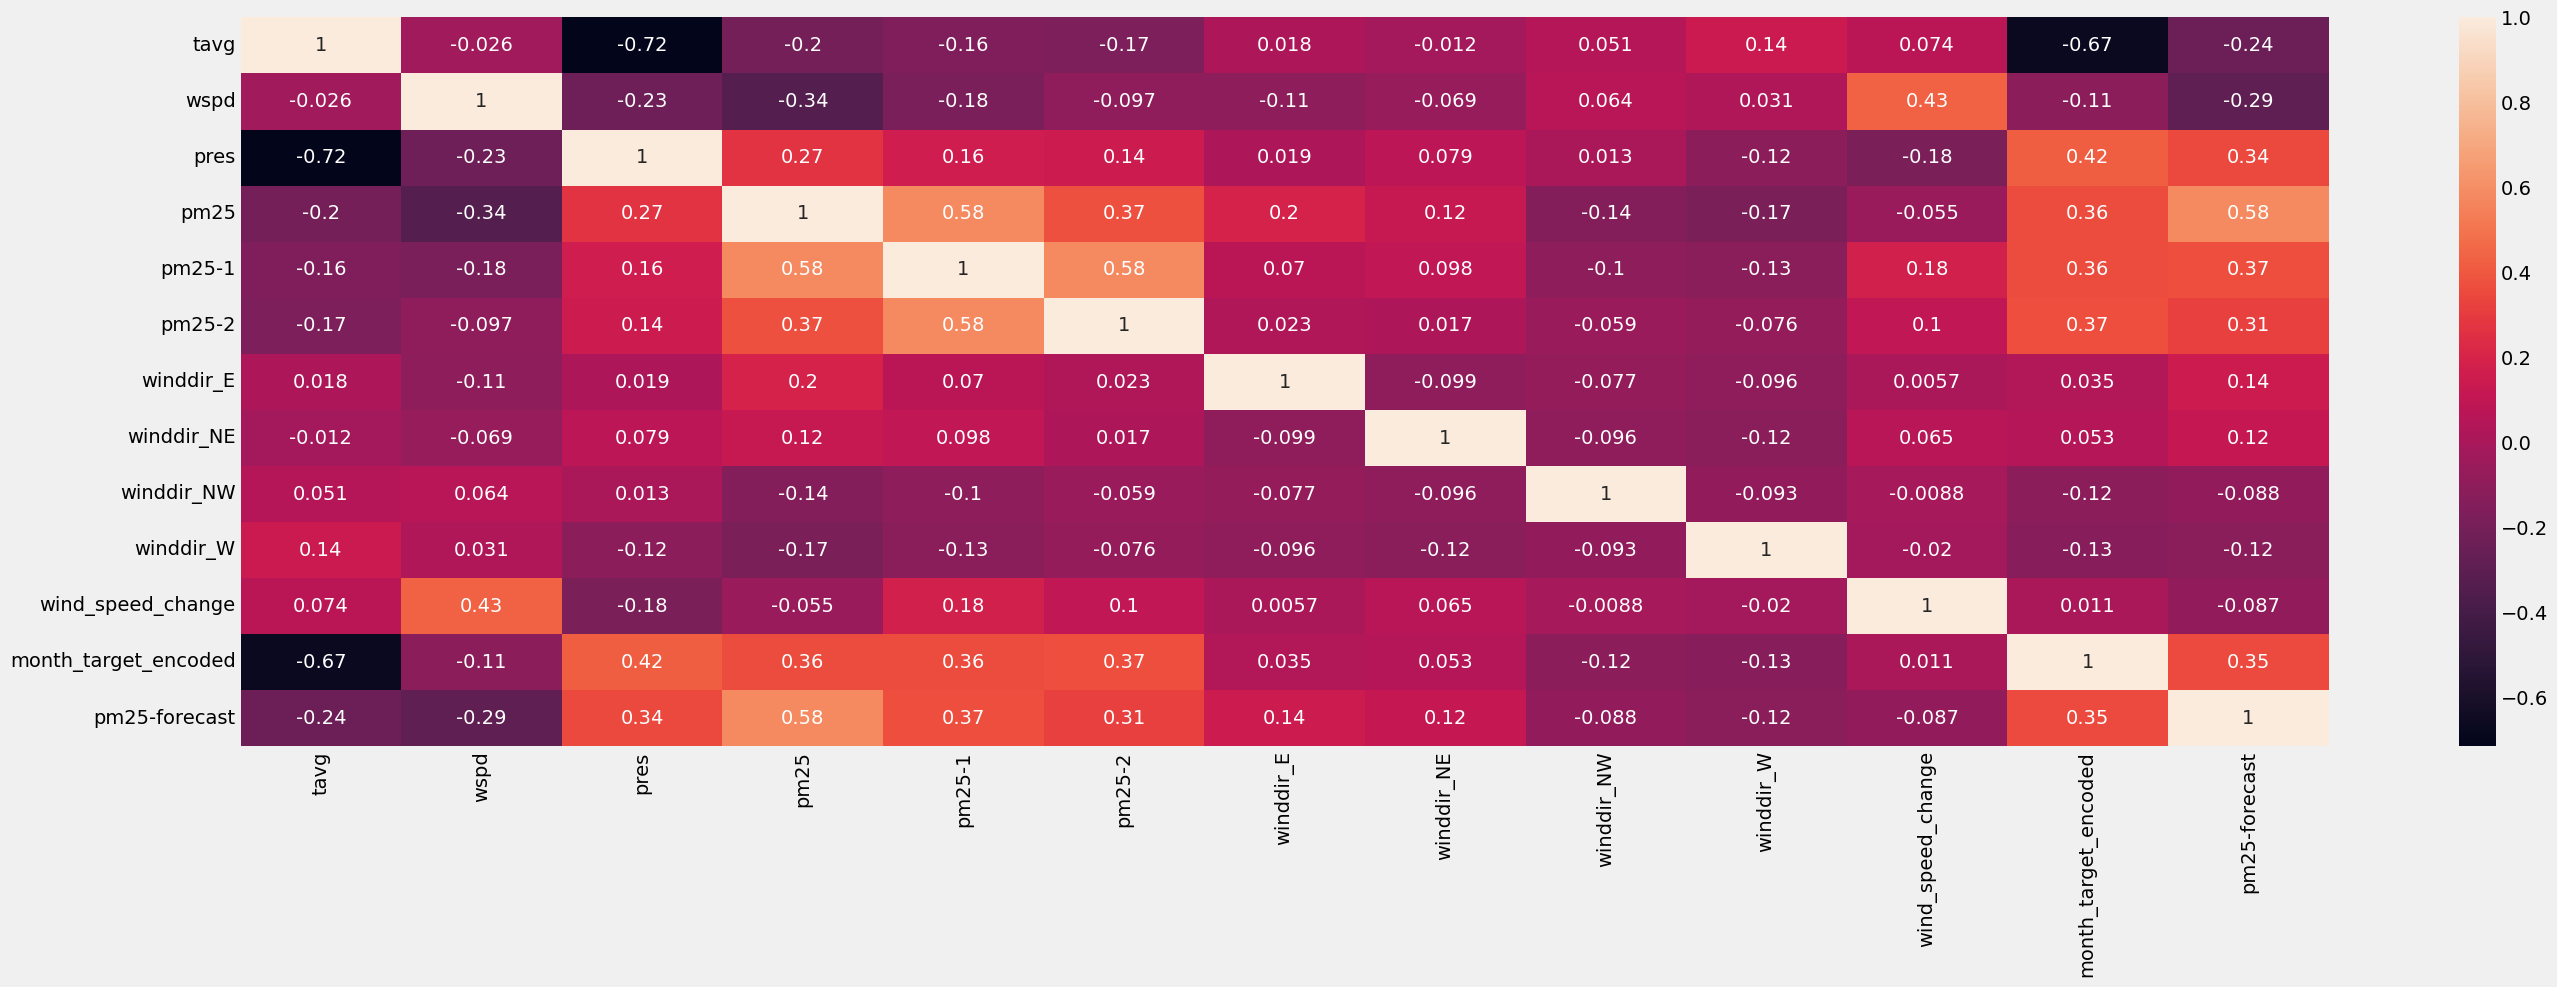

In [65]:
plt.figure(figsize=(30,9))
sns.heatmap(df_selected.corr(),annot=True);
plt.show()

# 5. Машинное обучение (ML)

In [67]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error

In [68]:
from sklearn.model_selection import train_test_split

# Separate features (X) and target variable (y)
X = df_selected.drop('pm25-forecast', axis=1)  # Features
y = df_selected['pm25-forecast']  # Target variable

Для лучших результатов обучения нормализируем данные:

In [70]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.fit_transform(X)
X

array([[0.10260337, 0.10328638, 0.74      , ..., 0.        , 0.45192308,
        0.67655494],
       [0.15313936, 0.11267606, 0.84714286, ..., 0.        , 0.48076923,
        0.671844  ],
       [0.09800919, 0.10328638, 0.97142857, ..., 0.        , 0.46153846,
        0.67345314],
       ...,
       [0.49004594, 0.25352113, 0.29571429, ..., 0.        , 0.59615385,
        0.62557158],
       [0.46094946, 0.14553991, 0.36      , ..., 0.        , 0.36057692,
        0.62557158],
       [0.44104135, 0.09389671, 0.52      , ..., 0.        , 0.41826923,
        0.62557158]])

Разделим данные на тренировочную и тестовую выборки/

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42) 

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (1095, 12)
Shape of y_train: (1095,)
Shape of X_test: (366, 12)
Shape of y_test: (366,)


In [73]:
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge, ElasticNet, BayesianRidge, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Lasso
#from sklearn.preprocessing import PolynomialFeatures

models = {
    'SVR': SVR(),
    'XGBRegressor': XGBRegressor(),
    'Ridge': Ridge(),
    'ElasticNet': ElasticNet(),
    'BayesianRidge': BayesianRidge(),
    'LinearRegression': LinearRegression(),
    'RandomForestRegressor': RandomForestRegressor(),
    'KNeighborsRegressor': KNeighborsRegressor(),
    'DecisionTreeRegressor': DecisionTreeRegressor(),
    'GaussianProcessRegressor': GaussianProcessRegressor(),
    'MLPRegressor': MLPRegressor(),
    'Lasso': Lasso()
}


Список используемых моделей регрессии

* Support Vector Regression (SVR): Метод опорных векторов для регрессии (SVR) находит оптимальную гиперплоскость, разделяющую данные с минимальной ошибкой.
* XGBoost: мощная библиотека градиентного бустинга, известная своей скоростью и точностью.
* Ridge Regression: вводит дполнительное слагаемое в функцию потерь, чтобы предотвратить переобучение модели.
* Lasso Regression: вводит дополнительное слагаемое, способствующее разреженности коэффициентов модели.
* ElasticNet: комбинирует штрафные функции Ридж- и Лассо-регрессии.
* Bayesian Ridge Regression: это байесовский подход к линейной регрессии.
* Linear Regression: Линейная регрессия — простая модель, которая подгоняет прямую линию к данным.
* Random Forest Regressor: Регрессор случайного леса — ансамблевый метод, объединяющий множество деревьев решений.
* K-Nearest Neighbors Regressor: Регрессор k-ближайших соседей предсказывает значение точки данных на основе значений ее k ближайших соседей.
* Decision Tree Regressor: Регрессор дерева решений создает древовидную модель для прогнозирования.
* Gaussian Process Regressor: обеспечивает вероятностные прогнозы.
* Multi-layer Perceptron Regressor: Многослойный перцептрон для регрессии — это нейронная сеть, используемая для задач регрессии.




In [75]:

model_names = []
model_rmse_results = []
model_mse_results = []
model_mae_results = []

# training the model with function
for name,model in models.items():
    a = model.fit(X_train,y_train)
    predicted = a.predict(X_test)
    mse = mean_squared_error(y_test, predicted)
    rmse = root_mean_squared_error(y_test, predicted)
    mae  = mean_absolute_error(y_test, predicted)
    model_names.append(name)
    model_rmse_results.append(rmse)
    model_mae_results.append(mae)
    model_mse_results.append(mse)
    
    #creating dataframe
    df_results = pd.DataFrame([model_names,model_mae_results,model_rmse_results,model_mse_results])
    df_results = df_results.transpose()
    df_results = df_results.rename(columns={0:'Model',1:'MAE',2:'MSE',3:'RMSE'}).sort_values(by='MSE',ascending=False)
    
print(df_results)

                       Model        MAE         MSE          RMSE
9   GaussianProcessRegressor  49.309097  145.806099  21259.418636
8      DecisionTreeRegressor   4.545585    7.009629     49.134901
11                     Lasso   4.364789    6.256583      39.14483
3                 ElasticNet   4.347545    6.232109     38.839185
7        KNeighborsRegressor   3.549663    5.545795      30.75584
1               XGBRegressor   3.636776    5.370831     28.845827
0                        SVR   3.268302    5.241524     27.473573
10              MLPRegressor   3.371643    5.056622     25.569421
6      RandomForestRegressor   3.367357    5.056413     25.567314
2                      Ridge   3.350396    5.035682     25.358091
5           LinearRegression   3.343824    5.035312     25.354363
4              BayesianRidge   3.347372    5.035112     25.352353


Попробуем оптимизировать гиперпараметры одной из моделей, для этого применим библиотеку optuna.
Выьерем RandomForestRegressor, так как у него  большое количество гиперпараметров модели применим.

In [77]:
# поиск гиперпараметров обернём в функцию
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 50, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 20, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель случайного леса
  model = RandomForestRegressor(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  # обучаем модель
  model.fit(X_train, y_train)
  predicted = model.predict(X_test)
  score = metrics.mean_absolute_error(y_test, predicted)
  return score

# %%time
# cоздаем объект исследования
study = optuna.create_study(study_name="RandomForestRegressor")
# ищем лучшую комбинацию гиперпараметров n_trials раз
#study.optimize(optuna_rf, n_trials=1000)
study.optimize(optuna_rf, n_trials=10)
#ВНИМАНИЕ! расчёт может занять большой период времени

[I 2025-02-08 11:59:41,958] A new study created in memory with name: RandomForestRegressor
[I 2025-02-08 11:59:42,701] Trial 0 finished with value: 3.317872517599269 and parameters: {'n_estimators': 148, 'max_depth': 12, 'min_samples_leaf': 8}. Best is trial 0 with value: 3.317872517599269.
[I 2025-02-08 11:59:43,159] Trial 1 finished with value: 3.326794946165372 and parameters: {'n_estimators': 91, 'max_depth': 11, 'min_samples_leaf': 8}. Best is trial 0 with value: 3.317872517599269.
[I 2025-02-08 11:59:43,925] Trial 2 finished with value: 3.3478045392567437 and parameters: {'n_estimators': 152, 'max_depth': 13, 'min_samples_leaf': 9}. Best is trial 0 with value: 3.317872517599269.
[I 2025-02-08 11:59:44,529] Trial 3 finished with value: 3.3252284500302447 and parameters: {'n_estimators': 105, 'max_depth': 10, 'min_samples_leaf': 3}. Best is trial 0 with value: 3.317872517599269.
[I 2025-02-08 11:59:45,360] Trial 4 finished with value: 3.3065406101221444 and parameters: {'n_estimato

были получены оптимальные параметры модели - {'n_estimators': 83, 'max_depth': 14 'min_samples_leaf': 6}. Обучим отдельно модель с этими параметрами:

In [79]:
# инициализируем модель 
a = RandomForestRegressor(max_depth=14,n_estimators=83, random_state=42, min_samples_leaf=6)
a.fit(X_train,y_train)
predicted = a.predict(X_test)
mse = mean_squared_error(y_test, predicted)
rmse = root_mean_squared_error(y_test, predicted)
mae  = mean_absolute_error(y_test, predicted)
print('MAE: %.3f' % mae)
print('RMSE: %.3f' % rmse)
print('MSE: %.3f' % mse)

MAE: 3.284
RMSE: 4.939
MSE: 24.393


Оптимизация гиперпараметров слегка улучшила метрику

## LTSM
LTSM (Long Short-Term Memory) это особый тип рекуррентной нейронной сети (RNN), который специально разработан для работы с последовательными данными, где порядок элементов имеет большое значение.
В этом разделе мы ее побробуем применить для предсказания покзателя PM2.5 без использования дополнительныз данных

Подготовим данные

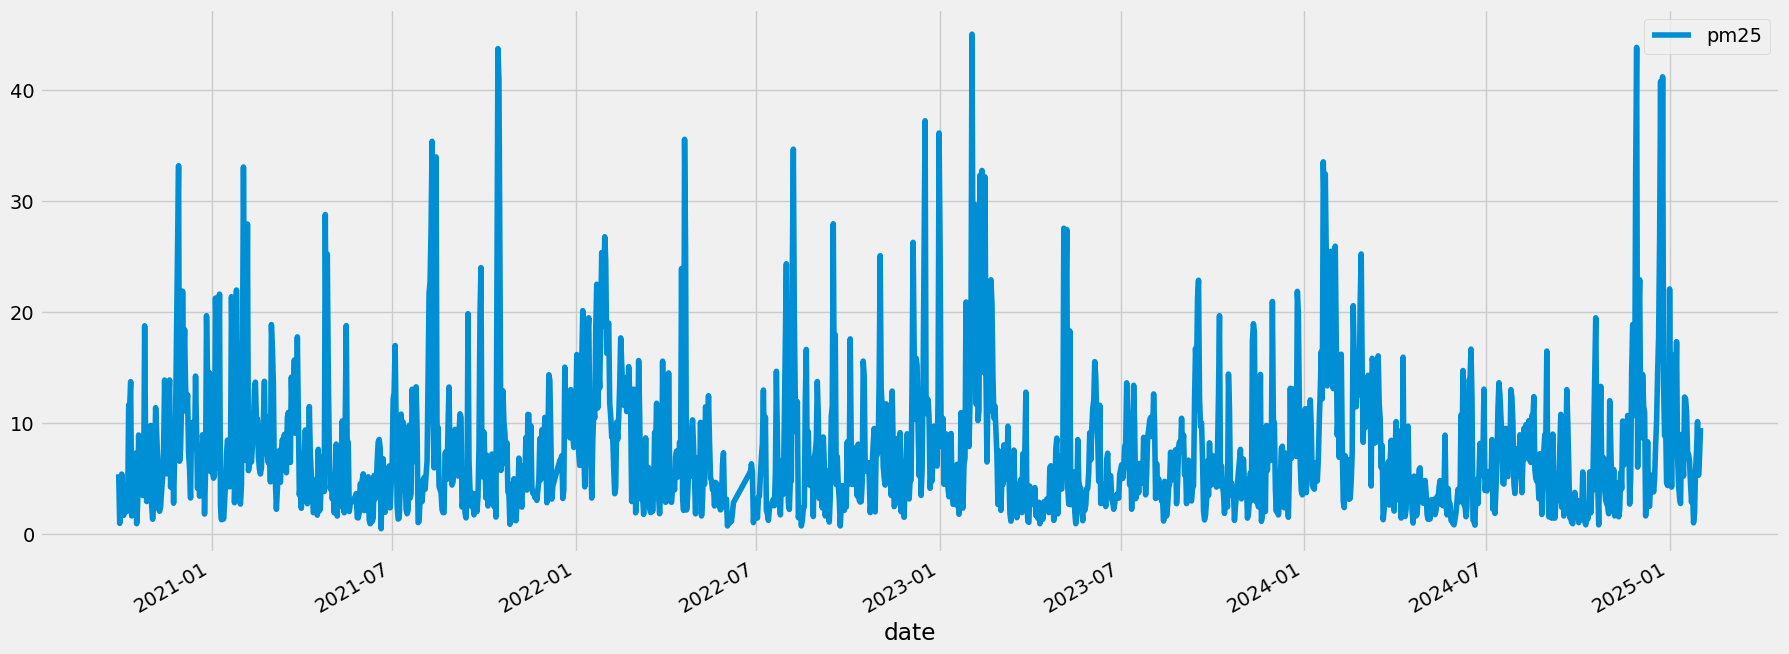

In [83]:
df_date=pd.DataFrame(df_pm25.groupby('date')['pm25'].mean())
df_date

df_date.plot(figsize=(20,8))
plt.show()

dataset  = df_date.values
training_data_len = math.ceil(len(dataset)*.75)
training_data_len

sc = MinMaxScaler(feature_range=(0,1))
scaled_data = sc.fit_transform(dataset)


In [84]:
train_data = scaled_data[0:training_data_len, :]
x_train = []
y_train = []
num = 60
for i in range(num, len(train_data)):
    x_train.append(train_data[i-num:i , 0])
    y_train.append(train_data[i , 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))


Зададим параметры LTSM

In [86]:


model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer = "adam", loss = "mean_absolute_error")

# model.fit(x_train,y_train, batch_size=10, epochs=10)

history = model.fit(x_train, y_train, epochs=50, batch_size=10)

Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.0907
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0869
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0834
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0821
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0816
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0805
Epoch 7/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0808
Epoch 8/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0784
Epoch 9/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0726
Epoch 10/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0812
Epoch 11/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0737
Epoch 12/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0726
Epoch 13/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0737
Epoch 14/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0727
Epoch 15/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s

In [87]:
test_data = scaled_data[training_data_len-60: , :]
x_test = []
y_test = dataset[training_data_len:,:]
for i in range(num, len(test_data)):
      x_test.append(test_data[i-num:i, 0])

In [88]:
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [89]:
predictions = model.predict(x_test)
predictions = sc.inverse_transform(predictions)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


In [90]:
# Расчет метрик
rmse = root_mean_squared_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)


print('LTSM MAE: %.3f' % mae)
print('LTSM RMSE: %.3f' % rmse)
print('LTSM MSE: %.3f' % mse)

LTSM MAE: 3.401
LTSM RMSE: 4.899
LTSM MSE: 24.004


In [91]:
train = df_date[:training_data_len]
valid = df_date[training_data_len:]
valid["Predictions"] = predictions
# valid

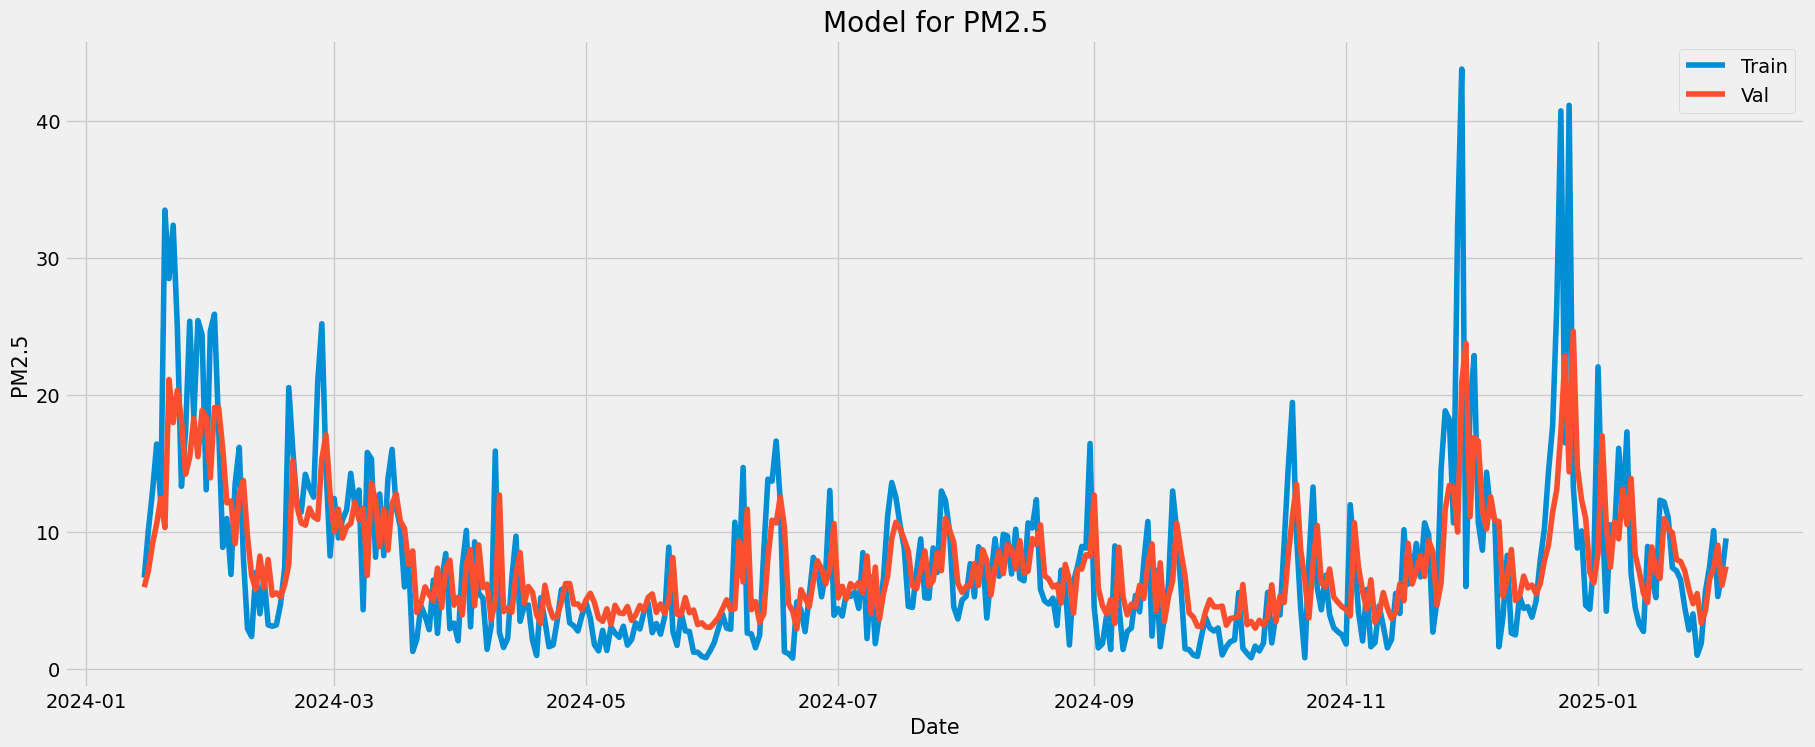

In [92]:
plt.figure(figsize=(20,8))
plt.title("Model for PM2.5")
plt.xlabel("Date", fontsize = 15)
plt.ylabel("PM2.5",fontsize=15)
#plt.plot(train[df_date.columns])
plt.plot(valid['pm25'])
plt.plot(valid["Predictions"])
plt.legend(["Train","Val","Predictions"])
plt.show()

## 7. Результаты

- В данном проекте были использованы  данные из разных истоников -  данные о концентрации PM2.5, полученном от сенсоа, установленном в городе Томске и метеорологичесие данные для того же города , с сентяьря 2020 года по текущий день, всего 1586 записей о работе вентилятора для лёгких. Данные были подробно изучены и агрегированы

- Сами данные были относительно качествено подготовлены - пропусков . Так что в качестве предобработки данных были создны новые признвки, ьыла изучена взаимная корреляция, удалены неинформативные признаки и произведена нормализация данных.

- Были испробованы следующие модели машинного обучения(оценка качества - MAE,MSE,RMSE):

  
        * Support Vector Regression (SVR): Метод опорных векторов для регрессии (SVR) находит оптимальную гиперплоскость, разделяющую данные с минимальной ошибкой.
        * XGBoost: библиотека градиентного бустинга, известная своей скоростью и точностью.
        * Ridge Regression: вводит дполнительное слагаемое в функцию потерь, чтобы предотвратить переобучение модели.
        * Lasso Regression: вводит дополнительное слагаемое, способствующее разреженности коэффициентов модели.
        * ElasticNet: комбинирует штрафные функции Ридж- и Лассо-регрессии.
        * Bayesian Ridge Regression: это байесовский подход к линейной регрессии.
        * Linear Regression: Линейная регрессия — простая модель, которая подгоняет прямую линию к данным.
        * Random Forest Regressor: Регрессор случайного леса — ансамблевый метод, объединяющий множество деревьев решений.
        * K-Nearest Neighbors Regressor: Регрессор k-ближайших соседей предсказывает значение точки данных на основе значений ее k ближайших соседей.
        * Decision Tree Regressor: Регрессор дерева решений создает древовидную модель для прогнозирования.
        * Gaussian Process Regressor: обеспечивает вероятностные прогнозы.
        * Multi-layer Perceptron Regressor: Многослойный перцептрон для регрессии — это нейронная сеть, используемая для задач регрессии.

    
- Лучший и близкий результат показали срзу несколько моделей с MAE = 3.3-3.4
    

| Model                       | MAE     | MSE     | RMSE     |
|-----------------------------|---------|---------|---------|
| SVR                         | 3.26830 | 5.24152 | 27.47357 |
| RandomForestRegressor       | 3.43161 | 5.15344 | 26.55790 |
| MLPRegressor                | 3.38017 | 5.06519 | 25.65611 |
| Ridge                        | 3.35040 | 5.03568 | 25.35809 |
| LinearRegression            | 3.34382 | 5.03531 | 25.35436 |
| BayesianRidge               | 3.34737 | 5.03511 | 25.35235 |

- для одной из моделей -RandomForestRegressor была проведена оптимизация гиперпараметров, что привело к улучшению метрики
    * MAE: 3.284
    * RMSE: 4.939
    * MSE: 24.393

- Для сравнения была проверена модель LTSM , результаты оказаличь близки 
    * LTSM MAE: 3.398
    * LTSM RMSE: 5.135
    * LTSM MSE: 26.366
      
То , что прогноз LTSM оказался не лучше, скорее асего,  объясняется тем, что для нее использовался только  данныве по PM2.5, дополнительные метеоданные  ей не использовалисью

### Возможности для улучшения
* проверка моделей на большем количестве данных  с большего количества точек
* подбор гиперпараметров для других  моделей регресии
* оптимизация модели LTSM - подбор количества эпох
* проверка других нейронных сетей
* добавления дополнительной информации для улучшеняи прогнозов
* сериализация модели для дальнейшего использования,  например в чат-боте